2024-06-20 09:35:39.391172: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 09:35:39.391207: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 09:35:39.391246: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-20 09:35:39.401170: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 14105 files belonging to 7 classes.


2024-06-20 09:35:44.552761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31103 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2024-06-20 09:35:44.553374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31119 MB memory:  -> device: 1, name: Tesla V100-DGXS-32GB, pci bus id: 0000:08:00.0, compute capability: 7.0


Epoch 1/30


2024-06-20 09:35:51.046812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-06-20 09:35:52.505433: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0e4cdeddc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-20 09:35:52.505469: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-DGXS-32GB, Compute Capability 7.0
2024-06-20 09:35:52.505481: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-DGXS-32GB, Compute Capability 7.0
2024-06-20 09:35:52.515687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-20 09:35:52.643933: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1234/1234 [==============================] - 32s 22ms/step - loss: 1.1209 - accuracy: 0.5541 - val_loss: 0.7260 - val_accuracy: 0.7170
Epoch 2/30
1234/1234 [==============================] - 26s 21ms/step - loss: 0.7775 - accuracy: 0.6854 - val_loss: 0.6581 - val_accuracy: 0.7269
Epoch 3/30
1234/1234 [==============================] - 26s 21ms/step - loss: 0.6975 - accuracy: 0.7116 - val_loss: 0.6052 - val_accuracy: 0.7607
Epoch 4/30
1234/1234 [==============================] - 25s 20ms/step - loss: 0.6569 - accuracy: 0.7357 - val_loss: 0.6003 - val_accuracy: 0.7624
Epoch 5/30
1234/1234 [==============================] - 25s 21ms/step - loss: 0.6344 - accuracy: 0.7447 - val_loss: 0.5897 - val_accuracy: 0.7663
Epoch 6/30
1234/1234 [==============================] - 26s 21ms/step - loss: 0.6246 - accuracy: 0.7495 - val_loss: 0.5747 - val_accuracy: 0.7734
Epoch 7/30
1234/1234 [==============================] - 26s 21ms/step - loss: 0.6077 - accuracy: 0.7493 - val_loss: 0.5790 - val_accura

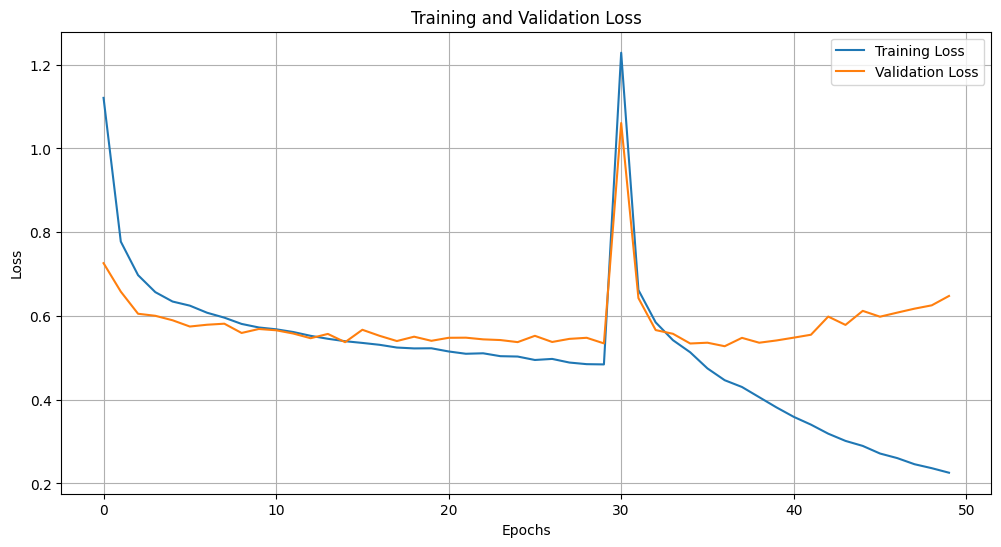

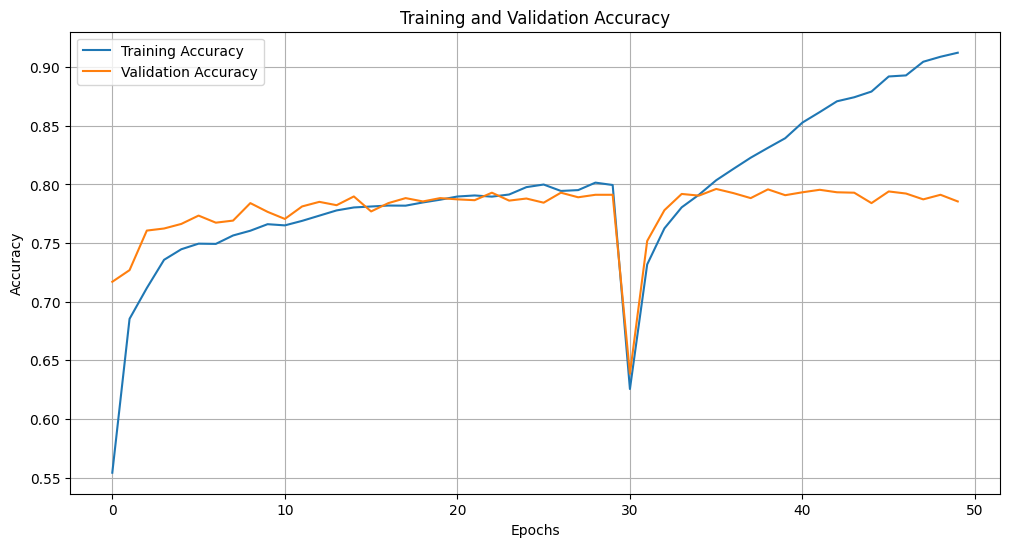

In [1]:
# Importiere notwendige Bibliotheken  Basismodell MobileNetV2 mit 30 Epochen  20 Epochen Fine-Tuning
import keras.optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

# Konfiguriere TensorFlow, um GPU 0 und 1 zu verwenden
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Beschränke TensorFlow darauf, nur die ersten zwei GPUs zu verwenden
        tf.config.experimental.set_visible_devices(gpus[:2], 'GPU')
        
        # Setze das Speicherwachstum, um zu verhindern, dass TensorFlow den gesamten GPU-Speicher von Anfang an belegt
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Sichtbare Geräte müssen festgelegt werden, bevor die GPUs initialisiert werden
        print(e)

# Datenaugmentation zur Vergrößerung des Trainingsdatensatzes
datagen = ImageDataGenerator(
    rescale=1./255,               # Reskalierung der Bildpixelwerte
    rotation_range=40,            # Zufällige Rotation der Bilder um bis zu 40 Grad
    width_shift_range=0.2,        # Zufällige horizontale Verschiebung der Bilder um bis zu 20%
    height_shift_range=0.2,       # Zufällige vertikale Verschiebung der Bilder um bis zu 20%
    shear_range=0.2,              # Zufälliges Scheren der Bilder um bis zu 20%
    zoom_range=0.2,               # Zufälliges Zoomen der Bilder um bis zu 20%
    horizontal_flip=True,         # Zufälliges horizontales Spiegeln der Bilder
    fill_mode='nearest',          # Auffüllen der durch Transformationen entstandenen leeren Pixel
    validation_split=0.2          # Verwendung von 20% der Daten für die Validierung
)

# Behalte die Bildgröße und reduziere die Batchgröße
data = tf.keras.utils.image_dataset_from_directory(
    'data',                # Verzeichnis, das die Bilder enthält
    image_size=(224, 224), # Größe der Bilder, die geladen werden sollen
    batch_size=8,          # Anzahl der Bilder pro Batch
    label_mode='categorical' # Kategorische Labels
)

# Teile den Datensatz auf
train_size = int(0.7 * len(data)) # 70% der Daten für das Training
val_size = int(0.2 * len(data))   # 20% der Daten für die Validierung
test_size = int(0.1 * len(data))  # 10% der Daten für das Testen

train = data.take(train_size)                 # Trainingsdatensatz
val = data.skip(train_size).take(val_size)    # Validierungsdatensatz
test = data.skip(train_size + val_size).take(test_size) # Testdatensatz

# Lade das Basis-Modell mit vortrainierten Gewichten
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',    # Vortrainierte Gewichte von ImageNet
    include_top=False,     # Schließe die obere Schicht des Modells aus
    input_shape=(224, 224, 3) # Eingabeform der Bilder
)

# Füge neue Schichten auf das Basis-Modell hinzu
x = base_model.output
x = GlobalAveragePooling2D()(x)     # Globale Durchschnittspoolingschicht
x = Dense(128, activation='relu')(x) # Vollständig verbundene Schicht mit 128 Einheiten und ReLU-Aktivierung
x = Dropout(0.5)(x)                  # Dropout-Schicht zur Reduktion von Overfitting
x = Dense(64, activation='relu')(x)  # Vollständig verbundene Schicht mit 64 Einheiten und ReLU-Aktivierung
predictions = Dense(units=7, activation='softmax')(x) # Ausgangsschicht mit 7 Klassen und Softmax-Aktivierung

# Erstelle das Modell
model = Model(inputs=base_model.input, outputs=predictions)

# Friere die Schichten des Basis-Modells ein
for layer in base_model.layers:
    layer.trainable = False

# Kompiliere das Modell
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Adam-Optimierer mit einer Lernrate von 0.0001
    loss='categorical_crossentropy',                      # Verlustfunktion
    metrics=['accuracy']                                  # Metrik zur Bewertung des Modells
)

# Trainiere das Modell
history = model.fit(
    train,                  # Trainingsdaten
    validation_data=val,    # Validierungsdaten
    epochs=30               # Anzahl der Epochen
)

# Enteise weitere Schichten im Basis-Modell für das Feintuning
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Kompiliere das Modell mit einer niedrigeren Lernrate neu
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001), # Adam-Optimierer mit einer Lernrate von 0.00001
    loss='categorical_crossentropy',                       # Verlustfunktion
    metrics=['accuracy']                                   # Metrik zur Bewertung des Modells
)

# Lernrate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = LearningRateScheduler(scheduler) # Callback für die Anpassung der Lernrate

# Feintune das Modell mit weiteren 20 Epochen
history_fine = model.fit(
    train,                  # Trainingsdaten
    validation_data=val,    # Validierungsdaten
    epochs=20,              # Anzahl der Epochen
    callbacks=[callback]    # Callback für die Anpassung der Lernrate
)

# Plotten des Trainings- und Validierungsverlustes
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotten der Trainings- und Validierungsgenauigkeit
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Visible devices cannot be modified after being initialized
Found 14105 files belonging to 7 classes.
Epoch 1/30
1234/1234 [==============================] - 38s 28ms/step - loss: 2.8640 - accuracy: 0.5444 - val_loss: 1.9150 - val_accuracy: 0.7120
Epoch 2/30
1234/1234 [==============================] - 34s 28ms/step - loss: 1.7866 - accuracy: 0.6721 - val_loss: 1.4981 - val_accuracy: 0.7298
Epoch 3/30
1234/1234 [==============================] - 36s 29ms/step - loss: 1.4810 - accuracy: 0.6995 - val_loss: 1.2907 - val_accuracy: 0.7411
Epoch 4/30
1234/1234 [==============================] - 36s 29ms/step - loss: 1.3019 - accuracy: 0.7167 - val_loss: 1.1538 - val_accuracy: 0.7543
Epoch 5/30
1234/1234 [==============================] - 36s 29ms/step - loss: 1.1775 - accuracy: 0.7289 - val_loss: 1.0563 - val_accuracy: 0.7642
Epoch 6/30
1234/1234 [==============================] - 36s 29ms/step - loss: 1.0970 - accuracy: 0.7323 - val_loss: 0.9845 - val_accuracy: 0.7688
Epoch 7/30
1234/1234 [=

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1234/1234 [==============================] - 42s 34ms/step - loss: 0.6164 - accuracy: 0.7961 - val_loss: 0.6224 - val_accuracy: 0.7930 - lr: 1.0000e-05
Epoch 8/20
1234/1234 [==============================] - 42s 34ms/step - loss: 0.6013 - accuracy: 0.8065 - val_loss: 0.6075 - val_accuracy: 0.7919 - lr: 1.0000e-05
Epoch 9/20
1234/1234 [==============================] - 43s 35ms/step - loss: 0.5889 - accuracy: 0.8102 - val_loss: 0.6072 - val_accuracy: 0.7955 - lr: 1.0000e-05
Epoch 10/20
1234/1234 [==============================] - 41s 33ms/step - loss: 0.5759 - accuracy: 0.8114 - val_loss: 0.6073 - val_accuracy: 0.7944 - lr: 1.0000e-05
Epoch 11/20
1234/1234 [==============================] - 42s 34ms/step - loss: 0.5630 - accuracy: 0.8201 - val_loss: 0.6061 - val_accuracy: 0.7990 - lr: 9.0484e-06
Epoch 12/20
1234/1234 [==============================] - 43s 35ms/step - loss: 0.5460 - accuracy: 0.8281 - val_loss: 0.6035 - val_accuracy: 0.7997 - lr: 8.1873e-06
Epoch 13/20
1234/1234 [=======

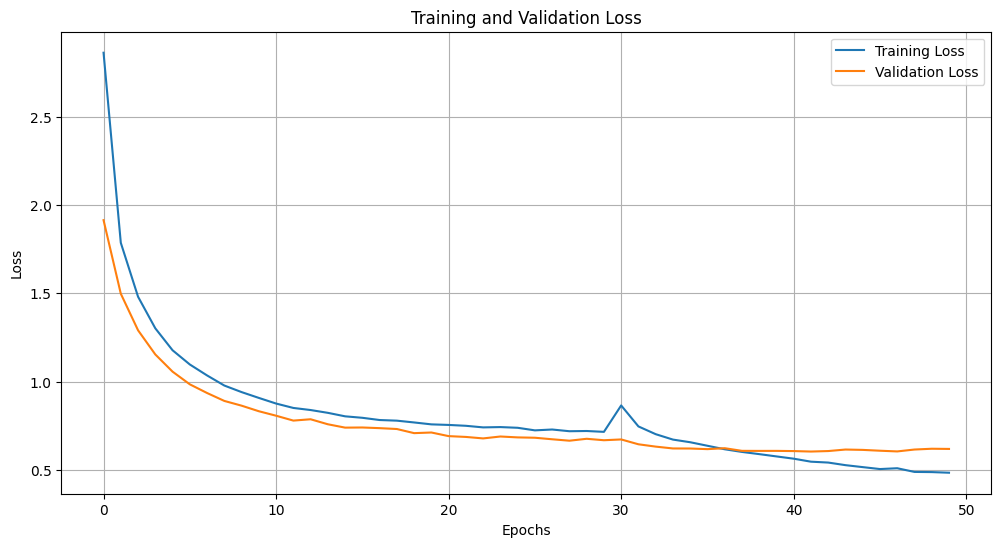

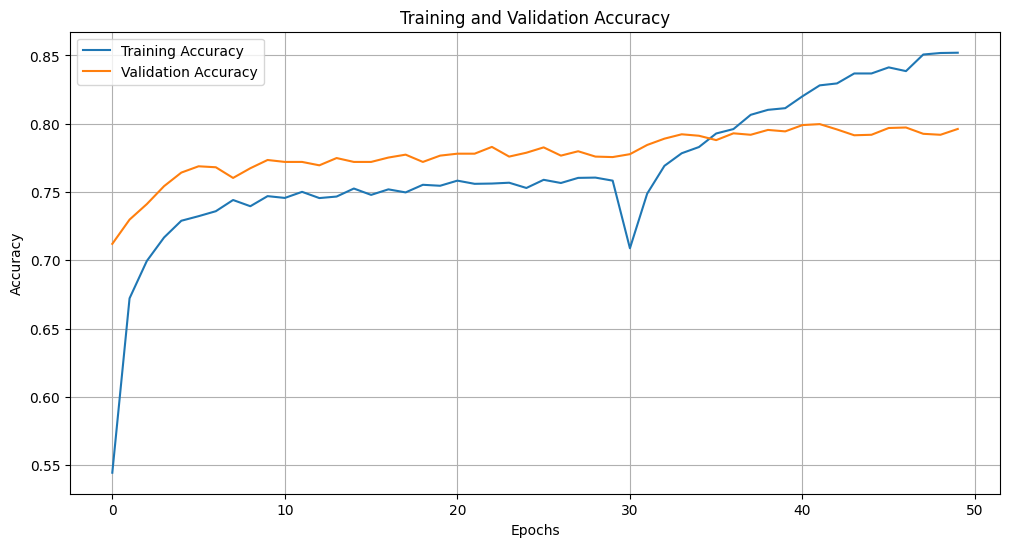

In [4]:

# Zweiter Run: Angepasstes Transfer Learning, Erhöhung der Modellkomplexität, L2-Regularisierung für Overfitting, Unfreeze Layer von -40 auf -20
# Änderungen:
# - Erhöhung der Modellkomplexität durch Hinzufügen von L2-Regularisierung
# - Anpassung der Anzahl der trainierbaren Schichten beim Fine-Tuning (von den letzten 40 auf die letzten 20 Schichten)

import keras.optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2

# Konfiguriere TensorFlow, um nur GPU 1 zu verwenden
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Beschränke TensorFlow darauf, nur GPU 1 zu verwenden
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        
        # Setze das Speicherwachstum, um zu verhindern, dass TensorFlow den gesamten GPU-Speicher von Anfang an belegt
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        # Sichtbare Geräte müssen festgelegt werden, bevor die GPUs initialisiert werden
        print(e)

# Datenaugmentation zur Vergrößerung des Trainingsdatensatzes
datagen = ImageDataGenerator(
    rescale=1./255,               # Reskalierung der Bildpixelwerte
    rotation_range=40,            # Zufällige Rotation der Bilder um bis zu 40 Grad
    width_shift_range=0.2,        # Zufällige horizontale Verschiebung der Bilder um bis zu 20%
    height_shift_range=0.2,       # Zufällige vertikale Verschiebung der Bilder um bis zu 20%
    shear_range=0.2,              # Zufälliges Scheren der Bilder um bis zu 20%
    zoom_range=0.2,               # Zufälliges Zoomen der Bilder um bis zu 20%
    horizontal_flip=True,         # Zufälliges horizontales Spiegeln der Bilder
    fill_mode='nearest',          # Auffüllen der durch Transformationen entstandenen leeren Pixel
    validation_split=0.2          # Verwendung von 20% der Daten für die Validierung
)

# Behalte die Bildgröße und reduziere die Batchgröße
data = tf.keras.utils.image_dataset_from_directory(
    'data',                # Verzeichnis, das die Bilder enthält
    image_size=(224, 224), # Größe der Bilder, die geladen werden sollen
    batch_size=8,          # Anzahl der Bilder pro Batch
    label_mode='categorical' # Kategorische Labels
)

# Teile den Datensatz auf
train_size = int(0.7 * len(data)) # 70% der Daten für das Training
val_size = int(0.2 * len(data))   # 20% der Daten für die Validierung
test_size = int(0.1 * len(data))  # 10% der Daten für das Testen

train = data.take(train_size)                 # Trainingsdatensatz
val = data.skip(train_size).take(val_size)    # Validierungsdatensatz
test = data.skip(train_size + val_size).take(test_size) # Testdatensatz

# Lade das Basis-Modell mit vortrainierten Gewichten
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',    # Vortrainierte Gewichte von ImageNet
    include_top=False,     # Schließe die obere Schicht des Modells aus
    input_shape=(224, 224, 3) # Eingabeform der Bilder
)

# Füge neue Schichten auf das Basis-Modell hinzu, angepasst mit Regularizer 0.01
x = base_model.output
x = GlobalAveragePooling2D()(x)     # Globale Durchschnittspoolingschicht
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x) # Vollständig verbundene Schicht mit 128 Einheiten, ReLU-Aktivierung und L2-Regularisierung
x = Dropout(0.5)(x)                  # Dropout-Schicht zur Reduktion von Overfitting
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)  # Vollständig verbundene Schicht mit 64 Einheiten, ReLU-Aktivierung und L2-Regularisierung
predictions = Dense(units=7, activation='softmax')(x) # Ausgangsschicht mit 7 Klassen und Softmax-Aktivierung

# Erstelle das Modell
model = Model(inputs=base_model.input, outputs=predictions)

# Friere die Schichten des Basis-Modells ein
for layer in base_model.layers:
    layer.trainable = False

# Kompiliere das Modell
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Adam-Optimierer mit einer Lernrate von 0.0001
    loss='categorical_crossentropy',                      # Verlustfunktion
    metrics=['accuracy']                                  # Metrik zur Bewertung des Modells
)

# Trainiere das Modell
history = model.fit(
    train,                  # Trainingsdaten
    validation_data=val,    # Validierungsdaten
    epochs=30               # Anzahl der Epochen
)

# Enteise weitere Schichten im Basis-Modell für das Feintuning
for layer in base_model.layers[-20:]:  # Unfreeze der letzten 20 Schichten des Basis-Modells
    layer.trainable = True

# Kompiliere das Modell mit einer niedrigeren Lernrate neu
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001), # Adam-Optimierer mit einer Lernrate von 0.00001
    loss='categorical_crossentropy',                       # Verlustfunktion
    metrics=['accuracy']                                   # Metrik zur Bewertung des Modells
)

# Lernrate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = LearningRateScheduler(scheduler) # Callback für die Anpassung der Lernrate

# Feintune das Modell mit weiteren 20 Epochen
history_fine = model.fit(
    train,                  # Trainingsdaten
    validation_data=val,    # Validierungsdaten
    epochs=20,              # Anzahl der Epochen
    callbacks=[callback]    # Callback für die Anpassung der Lernrate
)

# Plotten des Trainings- und Validierungsverlustes
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotten der Trainings- und Validierungsgenauigkeit
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Visible devices cannot be modified after being initialized
Found 14105 files belonging to 7 classes.
Epoch 1/30
1234/1234 [==============================] - 32s 22ms/step - loss: 8.0487 - accuracy: 0.4268 - val_loss: 5.1858 - val_accuracy: 0.6371
Epoch 2/30
1234/1234 [==============================] - 26s 21ms/step - loss: 4.3430 - accuracy: 0.6187 - val_loss: 3.3817 - val_accuracy: 0.7312
Epoch 3/30
1234/1234 [==============================] - 26s 21ms/step - loss: 2.9956 - accuracy: 0.6697 - val_loss: 2.4196 - val_accuracy: 0.7124
Epoch 4/30
1234/1234 [==============================] - 27s 22ms/step - loss: 2.2242 - accuracy: 0.6885 - val_loss: 1.8419 - val_accuracy: 0.7227
Epoch 5/30
1234/1234 [==============================] - 26s 21ms/step - loss: 1.7421 - accuracy: 0.7019 - val_loss: 1.4984 - val_accuracy: 0.7415
Epoch 6/30
1234/1234 [==============================] - 27s 22ms/step - loss: 1.4510 - accuracy: 0.7087 - val_loss: 1.2823 - val_accuracy: 0.7369
Epoch 7/30
1234/1234 [=

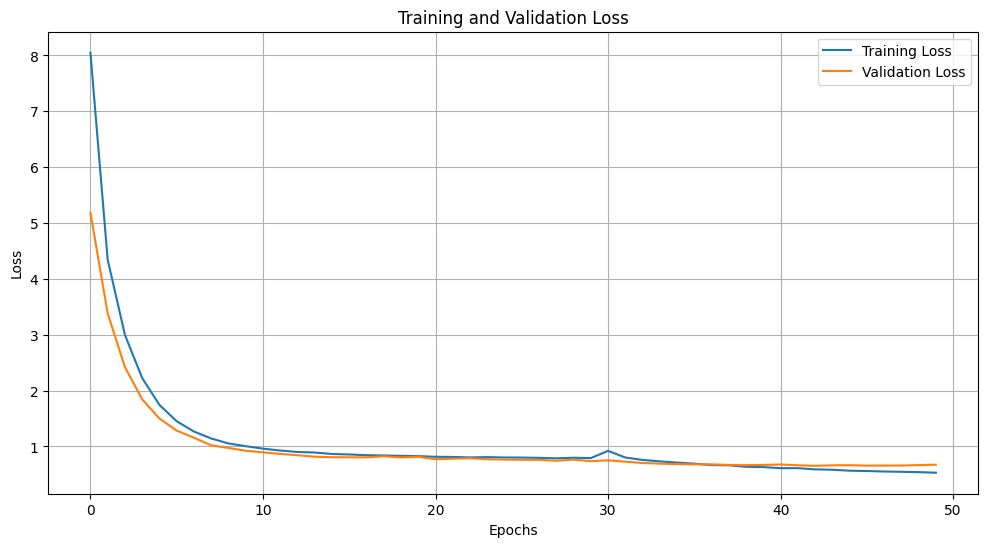

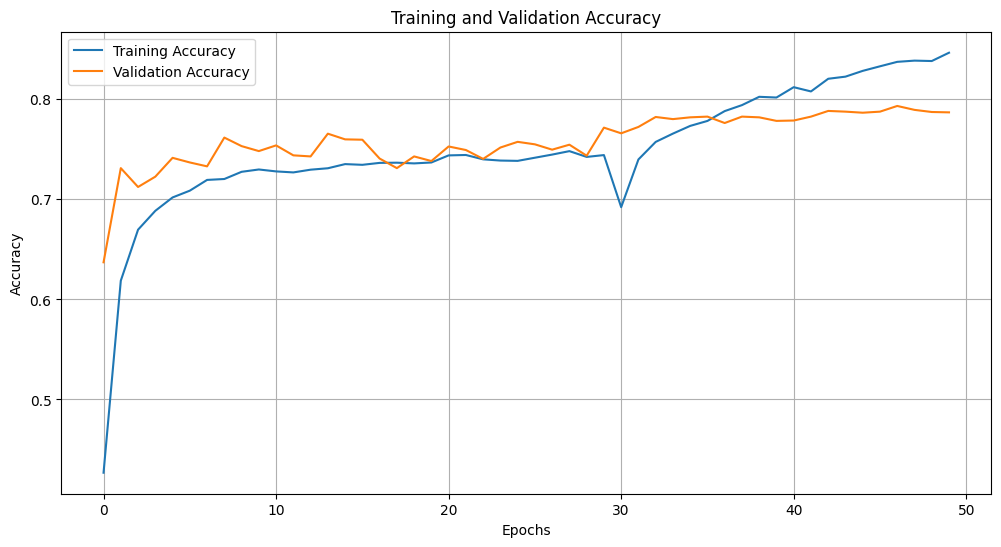

In [5]:
# Dritter Run: Angepasstes Transfer Learning, Hinzufügen weiterer Dense Layer
# Änderungen:
# - Hinzufügen weiterer Dense Layer zur Erhöhung der Modellkomplexität
# - Dense Layer mit 512, 256 und 128 Einheiten, jeweils mit ReLU-Aktivierung und L2-Regularisierung
# - Verwendung von Dropout nach jeder Dense Layer zur Reduktion von Overfitting


import keras.optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

from keras.regularizers import l2


# Configure TensorFlow to use only GPU 1
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use GPU 1
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        
        # Set memory growth to avoid TensorFlow allocating all GPU memory at the start
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        print(e)

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the data for validation
)

# Keep the image size and reduce the batch size
data = tf.keras.utils.image_dataset_from_directory('data', image_size=(224, 224), batch_size=8, label_mode='categorical')

# Split the dataset
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Load the base model with pre-trained weights
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new layers on top of the base model neu angepasst mit regularizer 0.01
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(units=7, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, validation_data=val, epochs=30)

# Unfreeze more layers in the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = LearningRateScheduler(scheduler)

# Fine-tune the model with more epochs 20 so far
history_fine = model.fit(train, validation_data=val, epochs=20, callbacks=[callback])

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Visible devices cannot be modified after being initialized
Found 14105 files belonging to 7 classes.
Epoch 1/50
1234/1234 [==============================] - 41s 30ms/step - loss: 8.3133 - accuracy: 0.4438 - val_loss: 5.4410 - val_accuracy: 0.6889
Epoch 2/50
1234/1234 [==============================] - 36s 29ms/step - loss: 4.5822 - accuracy: 0.6193 - val_loss: 3.5588 - val_accuracy: 0.7369
Epoch 3/50
1234/1234 [==============================] - 36s 29ms/step - loss: 3.1349 - accuracy: 0.6672 - val_loss: 2.5202 - val_accuracy: 0.7454
Epoch 4/50
1234/1234 [==============================] - 35s 28ms/step - loss: 2.3014 - accuracy: 0.6923 - val_loss: 1.9097 - val_accuracy: 0.7511
Epoch 5/50
1234/1234 [==============================] - 34s 28ms/step - loss: 1.7849 - accuracy: 0.7018 - val_loss: 1.5183 - val_accuracy: 0.7553
Epoch 6/50
1234/1234 [==============================] - 36s 29ms/step - loss: 1.4825 - accuracy: 0.7100 - val_loss: 1.3036 - val_accuracy: 0.7301
Epoch 7/50
1234/1234 [=

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1234/1234 [==============================] - 26s 21ms/step - loss: 0.7819 - accuracy: 0.7416 - val_loss: 0.7480 - val_accuracy: 0.7571
Epoch 37/50
1234/1234 [==============================] - 26s 21ms/step - loss: 0.7854 - accuracy: 0.7374 - val_loss: 0.7517 - val_accuracy: 0.7447
Epoch 38/50
1234/1234 [==============================] - 27s 21ms/step - loss: 0.7839 - accuracy: 0.7364 - val_loss: 0.7771 - val_accuracy: 0.7411
Epoch 39/50
1234/1234 [==============================] - 27s 21ms/step - loss: 0.7685 - accuracy: 0.7491 - val_loss: 0.7411 - val_accuracy: 0.7546
Epoch 40/50
1234/1234 [==============================] - 27s 22ms/step - loss: 0.7787 - accuracy: 0.7437 - val_loss: 0.7476 - val_accuracy: 0.7610
Epoch 41/50
1234/1234 [==============================] - 27s 22ms/step - loss: 0.7746 - accuracy: 0.7407 - val_loss: 0.7390 - val_accuracy: 0.7635
Epoch 42/50
1234/1234 [==============================] - 27s 21ms/step - loss: 0.7759 - accuracy: 0.7435 - val_loss: 0.7535 - val_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1234/1234 [==============================] - 35s 28ms/step - loss: 0.7397 - accuracy: 0.7618 - val_loss: 0.6876 - val_accuracy: 0.7770 - lr: 1.0000e-05
Epoch 4/30
1234/1234 [==============================] - 35s 28ms/step - loss: 0.7162 - accuracy: 0.7656 - val_loss: 0.6854 - val_accuracy: 0.7781 - lr: 1.0000e-05
Epoch 5/30
1234/1234 [==============================] - 35s 29ms/step - loss: 0.6916 - accuracy: 0.7770 - val_loss: 0.6858 - val_accuracy: 0.7770 - lr: 1.0000e-05
Epoch 6/30
1234/1234 [==============================] - 35s 29ms/step - loss: 0.6731 - accuracy: 0.7812 - val_loss: 0.6699 - val_accuracy: 0.7898 - lr: 1.0000e-05
Epoch 7/30
1234/1234 [==============================] - 36s 29ms/step - loss: 0.6576 - accuracy: 0.7876 - val_loss: 0.6729 - val_accuracy: 0.7844 - lr: 1.0000e-05
Epoch 8/30
1234/1234 [==============================] - 35s 29ms/step - loss: 0.6412 - accuracy: 0.7943 - val_loss: 0.6669 - val_accuracy: 0.7802 - lr: 1.0000e-05
Epoch 9/30
1234/1234 [===========

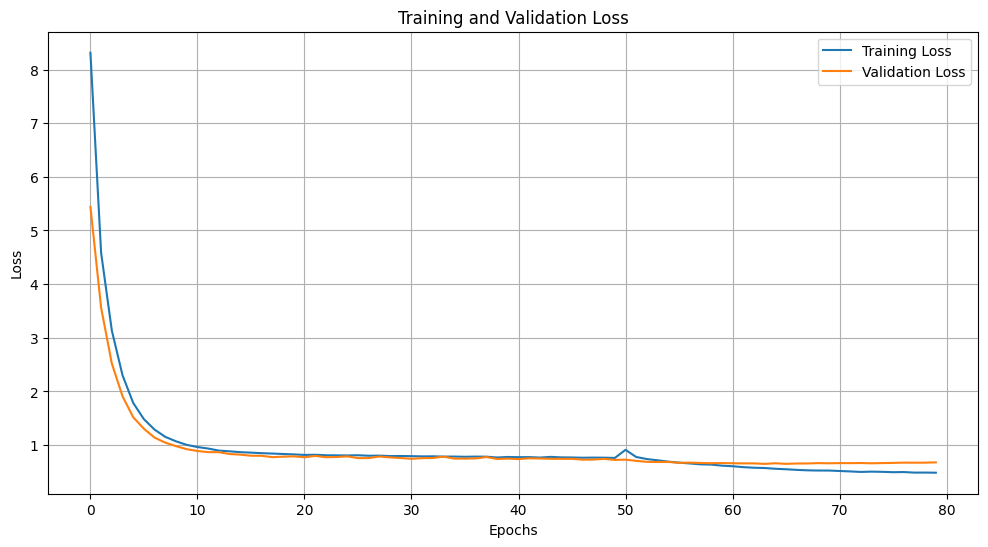

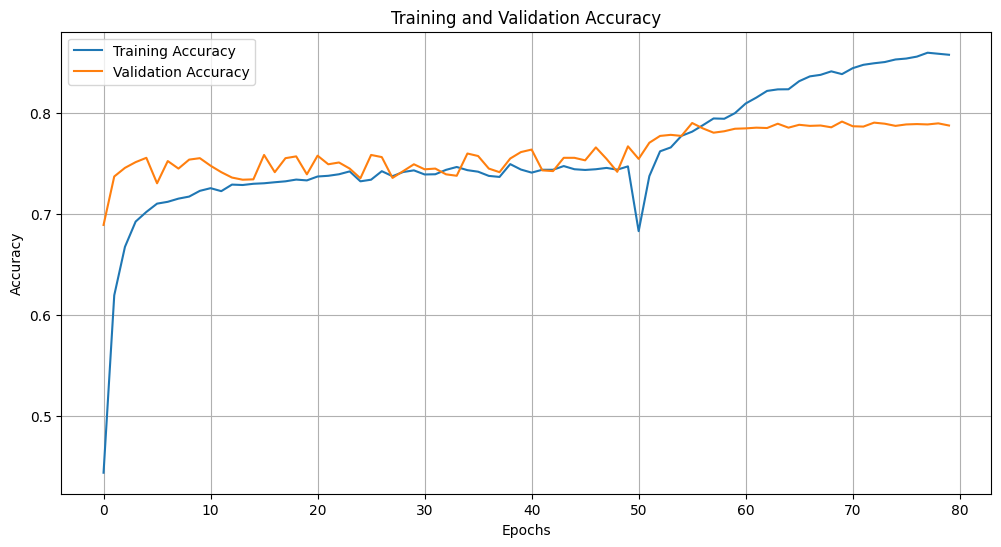

In [6]:
# 4ter Run: 50 Epochen, 30 Epochen Fine-Tuning
# Angepasstes Transfer Learning: Erhöhung der Modellkomplexität und Verwendung von L2-Regularisierung zur Vermeidung von Overfitting
# Änderungen: Erhöhung der Anzahl der Epochen für das Training und Fine-Tuning, Anpassung der Dense-Schichten

import keras.optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2

# Konfiguriere TensorFlow, um nur GPU 1 zu verwenden
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Beschränke TensorFlow darauf, nur GPU 1 zu verwenden
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        
        # Setze das Speicherwachstum, um zu verhindern, dass TensorFlow den gesamten GPU-Speicher von Anfang an belegt
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        # Sichtbare Geräte müssen festgelegt werden, bevor die GPUs initialisiert werden
        print(e)

# Datenaugmentation zur Vergrößerung des Trainingsdatensatzes
datagen = ImageDataGenerator(
    rescale=1./255,               # Reskalierung der Bildpixelwerte
    rotation_range=40,            # Zufällige Rotation der Bilder um bis zu 40 Grad
    width_shift_range=0.2,        # Zufällige horizontale Verschiebung der Bilder um bis zu 20%
    height_shift_range=0.2,       # Zufällige vertikale Verschiebung der Bilder um bis zu 20%
    shear_range=0.2,              # Zufälliges Scheren der Bilder um bis zu 20%
    zoom_range=0.2,               # Zufälliges Zoomen der Bilder um bis zu 20%
    horizontal_flip=True,         # Zufälliges horizontales Spiegeln der Bilder
    fill_mode='nearest',          # Auffüllen der durch Transformationen entstandenen leeren Pixel
    validation_split=0.2          # Verwendung von 20% der Daten für die Validierung
)

# Behalte die Bildgröße und reduziere die Batchgröße
data = tf.keras.utils.image_dataset_from_directory(
    'data',                # Verzeichnis, das die Bilder enthält
    image_size=(224, 224), # Größe der Bilder, die geladen werden sollen
    batch_size=8,          # Anzahl der Bilder pro Batch
    label_mode='categorical' # Kategorische Labels
)

# Teile den Datensatz auf
train_size = int(0.7 * len(data)) # 70% der Daten für das Training
val_size = int(0.2 * len(data))   # 20% der Daten für die Validierung
test_size = int(0.1 * len(data))  # 10% der Daten für das Testen

train = data.take(train_size)                 # Trainingsdatensatz
val = data.skip(train_size).take(val_size)    # Validierungsdatensatz
test = data.skip(train_size + val_size).take(test_size) # Testdatensatz

# Lade das Basis-Modell mit vortrainierten Gewichten
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',    # Vortrainierte Gewichte von ImageNet
    include_top=False,     # Schließe die obere Schicht des Modells aus
    input_shape=(224, 224, 3) # Eingabeform der Bilder
)

# Füge neue Schichten auf das Basis-Modell hinzu, angepasst mit Regularizer 0.01
x = base_model.output
x = GlobalAveragePooling2D()(x)     # Globale Durchschnittspoolingschicht
# Erhöhte Komplexität der dichten Schichten und Hinzufügen von L2-Regularisierung
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x) # Vollständig verbundene Schicht mit 512 Einheiten, ReLU-Aktivierung und L2-Regularisierung
x = Dropout(0.5)(x)                  # Dropout-Schicht zur Reduktion von Overfitting
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x) # Vollständig verbundene Schicht mit 256 Einheiten, ReLU-Aktivierung und L2-Regularisierung
x = Dropout(0.5)(x)                  # Dropout-Schicht zur Reduktion von Overfitting
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x) # Vollständig verbundene Schicht mit 128 Einheiten, ReLU-Aktivierung und L2-Regularisierung
x = Dropout(0.5)(x)                  # Dropout-Schicht zur Reduktion von Overfitting
predictions = Dense(units=7, activation='softmax')(x) # Ausgangsschicht mit 7 Klassen und Softmax-Aktivierung

# Erstelle das Modell
model = Model(inputs=base_model.input, outputs=predictions)

# Friere die Schichten des Basis-Modells ein
for layer in base_model.layers:
    layer.trainable = False

# Kompiliere das Modell
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Adam-Optimierer mit einer Lernrate von 0.0001
    loss='categorical_crossentropy',                      # Verlustfunktion
    metrics=['accuracy']                                  # Metrik zur Bewertung des Modells
)

# Trainiere das Modell
history = model.fit(
    train,                  # Trainingsdaten
    validation_data=val,    # Validierungsdaten
    epochs=50               # Anzahl der Epochen erhöht auf 50
)

# Enteise weitere Schichten im Basis-Modell für das Feintuning
for layer in base_model.layers[-20:]:  # Unfreeze der letzten 20 Schichten des Basis-Modells
    layer.trainable = True

# Kompiliere das Modell mit einer niedrigeren Lernrate neu
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001), # Adam-Optimierer mit einer Lernrate von 0.00001
    loss='categorical_crossentropy',                       # Verlustfunktion
    metrics=['accuracy']                                   # Metrik zur Bewertung des Modells
)

# Lernrate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = LearningRateScheduler(scheduler) # Callback für die Anpassung der Lernrate

# Feintune das Modell mit weiteren 30 Epochen
history_fine = model.fit(
    train,                  # Trainingsdaten
    validation_data=val,    # Validierungsdaten
    epochs=30,              # Anzahl der Epochen für das Fine-Tuning erhöht auf 30
    callbacks=[callback]    # Callback für die Anpassung der Lernrate
)

# Plotten des Trainings- und Validierungsverlustes
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotten der Trainings- und Validierungsgenauigkeit
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Found 14105 files belonging to 7 classes.
87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/50


2024-06-20 19:26:04.117172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-06-20 19:26:05.019671: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f62b0faf560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-20 19:26:05.019705: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-DGXS-32GB, Compute Capability 7.0
2024-06-20 19:26:05.028914: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-20 19:26:05.149378: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1234/1234 [==============================] - 45s 32ms/step - loss: 3.5222 - accuracy: 0.6024 - val_loss: 2.8069 - val_accuracy: 0.6499
Epoch 2/50
1234/1234 [==============================] - 37s 30ms/step - loss: 2.2265 - accuracy: 0.6516 - val_loss: 1.5717 - val_accuracy: 0.6989
Epoch 3/50
1234/1234 [==============================] - 37s 30ms/step - loss: 1.7722 - accuracy: 0.6772 - val_loss: 1.3925 - val_accuracy: 0.6893
Epoch 4/50
1234/1234 [==============================] - 37s 30ms/step - loss: 1.5290 - accuracy: 0.6793 - val_loss: 1.2243 - val_accuracy: 0.6964
Epoch 5/50
1234/1234 [==============================] - 37s 30ms/step - loss: 1.4286 - accuracy: 0.6872 - val_loss: 1.0894 - val_accuracy: 0.6864
Epoch 6/50
1234/1234 [==============================] - 37s 30ms/step - loss: 1.3043 - accuracy: 0.6951 - val_loss: 1.1796 - val_accuracy: 0.6996
Epoch 7/50
1234/1234 [==============================] - 37s 30ms/step - loss: 0.7017 - accuracy: 0.7322 - val_loss: 0.7874 - val_accura

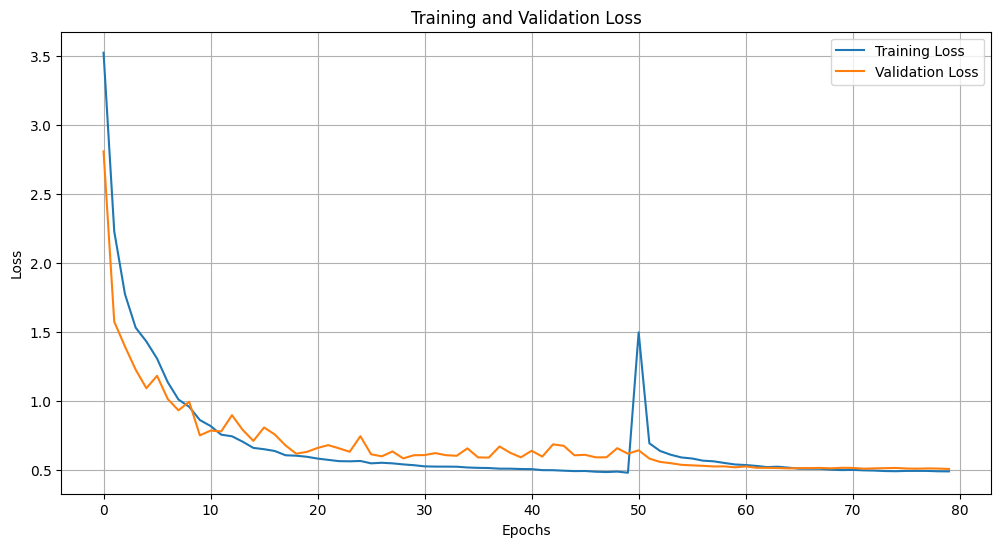

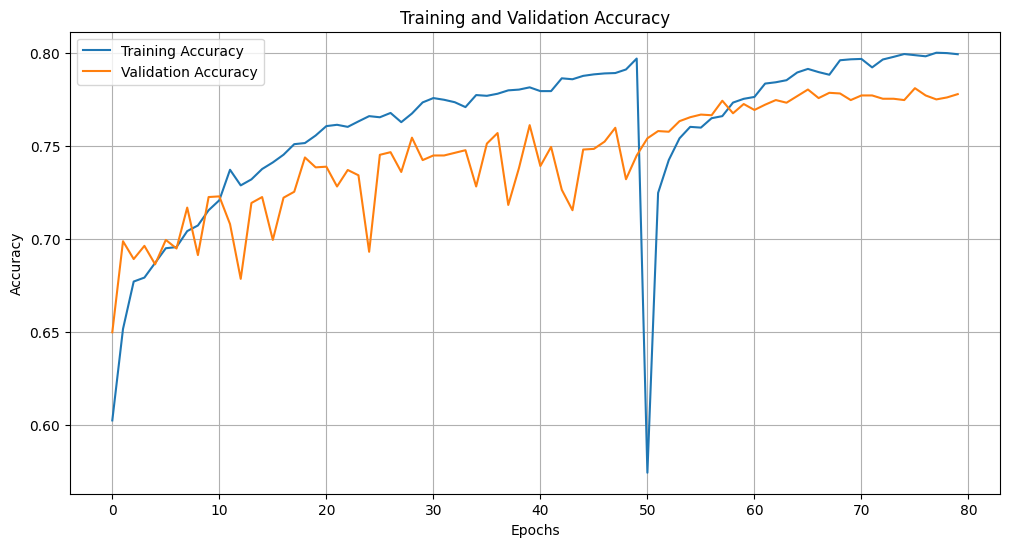

In [2]:
# Neuer Run mit neuem Modell: InceptionV3
# 5ter Run: 50 Epochen, 30 Epochen Fine-Tuning
# Angepasstes Transfer Learning: Erhöhung der Modellkomplexität und Verwendung von L2-Regularisierung zur Vermeidung von Overfitting

import keras.optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import InceptionV3
from keras.regularizers import l2

# Konfiguriere TensorFlow, um nur GPU 1 zu verwenden
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Beschränke TensorFlow darauf, nur GPU 1 zu verwenden
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        
        # Setze das Speicherwachstum, um zu verhindern, dass TensorFlow den gesamten GPU-Speicher von Anfang an belegt
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        # Sichtbare Geräte müssen festgelegt werden, bevor die GPUs initialisiert werden
        print(e)

# Datenaugmentation zur Vergrößerung des Trainingsdatensatzes
datagen = ImageDataGenerator(
    rescale=1./255,               # Reskalierung der Bildpixelwerte
    rotation_range=40,            # Zufällige Rotation der Bilder um bis zu 40 Grad
    width_shift_range=0.2,        # Zufällige horizontale Verschiebung der Bilder um bis zu 20%
    height_shift_range=0.2,       # Zufällige vertikale Verschiebung der Bilder um bis zu 20%
    shear_range=0.2,              # Zufälliges Scheren der Bilder um bis zu 20%
    zoom_range=0.2,               # Zufälliges Zoomen der Bilder um bis zu 20%
    horizontal_flip=True,         # Zufälliges horizontales Spiegeln der Bilder
    fill_mode='nearest',          # Auffüllen der durch Transformationen entstandenen leeren Pixel
    validation_split=0.2          # Verwendung von 20% der Daten für die Validierung
)

# Behalte die Bildgröße und reduziere die Batchgröße
data = tf.keras.utils.image_dataset_from_directory(
    'data',                # Verzeichnis, das die Bilder enthält
    image_size=(224, 224), # Größe der Bilder, die geladen werden sollen
    batch_size=8,          # Anzahl der Bilder pro Batch
    label_mode='categorical' # Kategorische Labels
)

# Teile den Datensatz auf
train_size = int(0.7 * len(data)) # 70% der Daten für das Training
val_size = int(0.2 * len(data))   # 20% der Daten für die Validierung
test_size = int(0.1 * len(data))  # 10% der Daten für das Testen

train = data.take(train_size)                 # Trainingsdatensatz
val = data.skip(train_size).take(val_size)    # Validierungsdatensatz
test = data.skip(train_size + val_size).take(test_size) # Testdatensatz

# Lade das Basis-Modell mit vortrainierten Gewichten
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Füge neue Schichten auf das Basis-Modell hinzu, angepasst mit Regularizer 0.01
x = base_model.output
x = GlobalAveragePooling2D()(x)     # Globale Durchschnittspoolingschicht
# Erhöhte Komplexität der dichten Schichten und Hinzufügen von L2-Regularisierung
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x) # Vollständig verbundene Schicht mit 512 Einheiten, ReLU-Aktivierung und L2-Regularisierung
x = Dropout(0.5)(x)                  # Dropout-Schicht zur Reduktion von Overfitting
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x) # Vollständig verbundene Schicht mit 256 Einheiten, ReLU-Aktivierung und L2-Regularisierung
x = Dropout(0.5)(x)                  # Dropout-Schicht zur Reduktion von Overfitting
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x) # Vollständig verbundene Schicht mit 128 Einheiten, ReLU-Aktivierung und L2-Regularisierung
x = Dropout(0.5)(x)                  # Dropout-Schicht zur Reduktion von Overfitting
predictions = Dense(units=7, activation='softmax')(x) # Ausgangsschicht mit 7 Klassen und Softmax-Aktivierung

# Erstelle das Modell
model = Model(inputs=base_model.input, outputs=predictions)

# Friere die Schichten des Basis-Modells ein
for layer in base_model.layers:
    layer.trainable = False

# Kompiliere das Modell
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Adam-Optimierer mit einer Lernrate von 0.0001
    loss='categorical_crossentropy',                      # Verlustfunktion
    metrics=['accuracy']                                  # Metrik zur Bewertung des Modells
)

# Trainiere das Modell
history = model.fit(
    train,                  # Trainingsdaten
    validation_data=val,    # Validierungsdaten
    epochs=50               # Anzahl der Epochen erhöht auf 50
)

# Enteise weitere Schichten im Basis-Modell für das Feintuning
for layer in base_model.layers[-20:]:  # Unfreeze der letzten 20 Schichten des Basis-Modells
    layer.trainable = True

# Kompiliere das Modell mit einer niedrigeren Lernrate neu
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001), # Adam-Optimierer mit einer Lernrate von 0.00001
    loss='categorical_crossentropy',                       # Verlustfunktion
    metrics=['accuracy']                                   # Metrik zur Bewertung des Modells
)

# Lernrate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = LearningRateScheduler(scheduler) # Callback für die Anpassung der Lernrate

# Feintune das Modell mit weiteren 30 Epochen
history_fine = model.fit(
    train,                  # Trainingsdaten
    validation_data=val,    # Validierungsdaten
    epochs=30,              # Anzahl der Epochen für das Fine-Tuning erhöht auf 30
    callbacks=[callback]    # Callback für die Anpassung der Lernrate
)

# Plotten des Trainings- und Validierungsverlustes
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotten der Trainings- und Validierungsgenauigkeit
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
